# G4: Augmentation

## 1. Augmentation을 적용한 dataset

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# 공개되어 있는 많은 데이터셋들의 원본을 tfds 모듈로 불러들일 수 있다.
import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

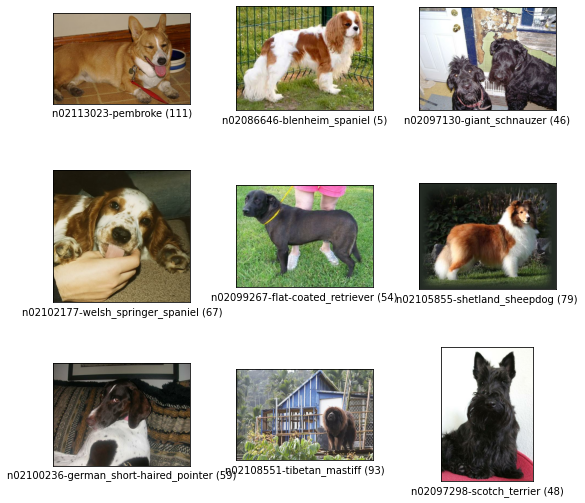

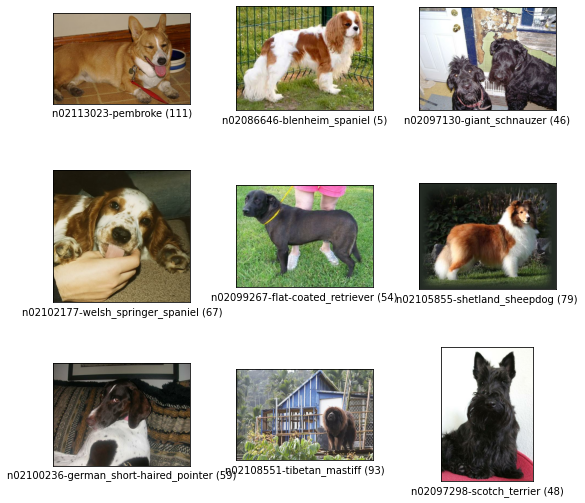

In [4]:
tfds.show_examples(ds_train, ds_info)

####  Augmentation

#### Random Augmentation 
- random_brightness() : 명도조절
- random_contrast() : 대비
- random_crop() : 이미지를 대상 높이와 너비에 맞게 무작위로 자름.
- random_flip_left_right() : 좌우대칭
- random_flip_up_down() : 상하대칭
- random_hue() : 색상조절
- random_jpeg_quality() : 
- random_saturation() : 채도조절

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [7]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

####  CutMix Augmentation

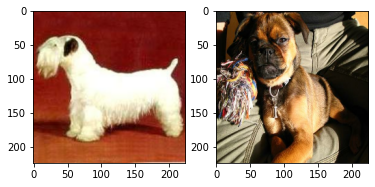

In [9]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [10]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [11]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(59, shape=(), dtype=int32) tf.Tensor(213, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(125, shape=(), dtype=int32)


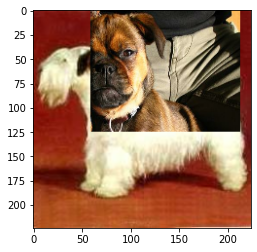

In [12]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [13]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.6163504 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [14]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

####  Mixup Augmentation

In [15]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

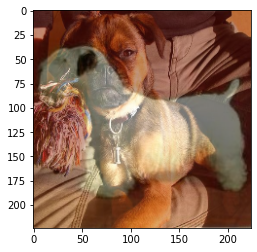

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.4471705 0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [16]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [17]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

####  데이터셋 제작

In [18]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [19]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [20]:
# augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋 생성
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

---
---

## 2. 모델제작

####  No  Augmentation

In [21]:
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')  # 데이터에 맞는 FC layer 붙여서 활용
])

####  Augmentation

In [22]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

#### CutMix Augmentation

In [23]:
cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

####  Mixup Augmentation

In [24]:
mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

---
---

## 3. 모델훈련

In [25]:
EPOCH = 20
tf.random.set_seed(0)

no_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

####  No Augmentation

In [26]:
his_no_aug_resnet50 = no_aug_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 351s 431ms/step - loss: 3.1524 - accuracy: 0.2883 - val_loss: 3.5044 - val_accuracy: 0.1845
Epoch 2/20
750/750 [==============================] - 323s 431ms/step - loss: 0.9314 - accuracy: 0.7383 - val_loss: 1.0354 - val_accuracy: 0.6936
Epoch 3/20
750/750 [==============================] - 323s 431ms/step - loss: 0.3171 - accuracy: 0.9254 - val_loss: 0.9639 - val_accuracy: 0.7127
Epoch 4/20
750/750 [==============================] - 323s 431ms/step - loss: 0.0963 - accuracy: 0.9891 - val_loss: 0.9140 - val_accuracy: 0.7303
Epoch 5/20
750/750 [==============================] - 324s 432ms/step - loss: 0.0339 - accuracy: 0.9982 - val_loss: 0.9122 - val_accuracy: 0.7378
Epoch 6/20
750/750 [==============================] - 323s 431ms/step - loss: 0.0165 - accuracy: 0.9997 - val_loss: 0.9217 - val_accuracy: 0.7360
Epoch 7/20
750/750 [==============================] - 323s 431ms/step - loss: 0.0240 - accuracy: 0.9995 - val_loss: 0.9527 -

#### Augmentation

In [27]:
his_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 333s 436ms/step - loss: 3.2360 - accuracy: 0.2645 - val_loss: 2.8683 - val_accuracy: 0.2851
Epoch 2/20
750/750 [==============================] - 331s 442ms/step - loss: 1.0851 - accuracy: 0.6868 - val_loss: 1.2936 - val_accuracy: 0.6164
Epoch 3/20
750/750 [==============================] - 331s 441ms/step - loss: 0.5554 - accuracy: 0.8456 - val_loss: 1.2513 - val_accuracy: 0.6521
Epoch 4/20
750/750 [==============================] - 331s 441ms/step - loss: 0.3725 - accuracy: 0.9028 - val_loss: 1.1258 - val_accuracy: 0.6803
Epoch 5/20
750/750 [==============================] - 331s 441ms/step - loss: 0.1975 - accuracy: 0.9572 - val_loss: 1.1109 - val_accuracy: 0.6974
Epoch 6/20
750/750 [==============================] - 331s 441ms/step - loss: 0.1018 - accuracy: 0.9835 - val_loss: 1.0181 - val_accuracy: 0.7186
Epoch 7/20
750/750 [==============================] - 331s 441ms/step - loss: 0.0574 - accuracy: 0.9930 - val_loss: 0.9860 -

####  CutMix Augmentation

In [28]:
his_cutmix_aug_resnet50 = cutmix_aug_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 332s 434ms/step - loss: 4.3412 - accuracy: 0.1153 - val_loss: 3.3440 - val_accuracy: 0.2009
Epoch 2/20
750/750 [==============================] - 325s 434ms/step - loss: 3.0483 - accuracy: 0.4060 - val_loss: 1.5431 - val_accuracy: 0.5781
Epoch 3/20
750/750 [==============================] - 325s 433ms/step - loss: 2.7193 - accuracy: 0.5063 - val_loss: 1.4071 - val_accuracy: 0.6128
Epoch 4/20
750/750 [==============================] - 324s 432ms/step - loss: 2.4971 - accuracy: 0.5806 - val_loss: 1.4494 - val_accuracy: 0.6110
Epoch 5/20
750/750 [==============================] - 324s 432ms/step - loss: 2.3636 - accuracy: 0.6165 - val_loss: 1.4189 - val_accuracy: 0.6178
Epoch 6/20
750/750 [==============================] - 324s 432ms/step - loss: 2.1941 - accuracy: 0.6708 - val_loss: 1.2489 - val_accuracy: 0.6706
Epoch 7/20
750/750 [==============================] - 324s 432ms/step - loss: 2.1077 - accuracy: 0.7025 - val_loss: 1.3155 -

#### Mixup Augmentation

In [29]:
his_mixup_aug_resnet50 = mixup_aug_resnet50.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 331s 434ms/step - loss: 3.2131 - accuracy: 0.2726 - val_loss: 3.5188 - val_accuracy: 0.1819
Epoch 2/20
750/750 [==============================] - 325s 433ms/step - loss: 0.8959 - accuracy: 0.7498 - val_loss: 1.1290 - val_accuracy: 0.6735
Epoch 3/20
750/750 [==============================] - 325s 433ms/step - loss: 0.2936 - accuracy: 0.9321 - val_loss: 0.9531 - val_accuracy: 0.7219
Epoch 4/20
750/750 [==============================] - 324s 432ms/step - loss: 0.0750 - accuracy: 0.9909 - val_loss: 0.9186 - val_accuracy: 0.7409
Epoch 5/20
750/750 [==============================] - 324s 432ms/step - loss: 0.0305 - accuracy: 0.9993 - val_loss: 0.9382 - val_accuracy: 0.7385
Epoch 6/20
750/750 [==============================] - 324s 432ms/step - loss: 0.0184 - accuracy: 0.9997 - val_loss: 0.9494 - val_accuracy: 0.7360
Epoch 7/20
750/750 [==============================] - 324s 432ms/step - loss: 0.0305 - accuracy: 0.9975 - val_loss: 0.9682 -

---
---

## 5. 시각화

####  Accuracy

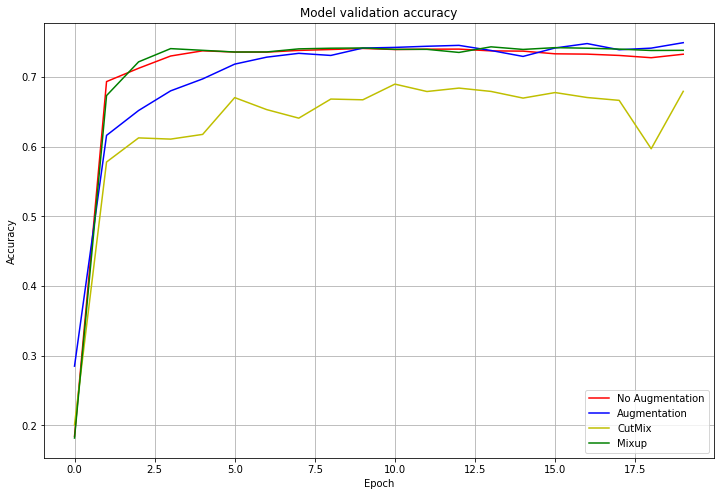

In [30]:
plt.figure(figsize=(12, 8))
plt.plot(his_no_aug_resnet50.history['val_accuracy'], 'r')
plt.plot(his_aug_resnet50.history['val_accuracy'], 'b')
plt.plot(his_cutmix_aug_resnet50.history['val_accuracy'], 'y')
plt.plot(his_mixup_aug_resnet50.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='lower right')
plt.grid(True)
plt.show()

#### Loss

---
---

## 성능비교

In [32]:
import pandas as pd

In [33]:
acc_data = {'No Augmentation': his_no_aug_resnet50.history['val_accuracy'], 
            'Augmentation': his_aug_resnet50.history['val_accuracy'], 
            'CutMix': his_cutmix_aug_resnet50.history['val_accuracy'], 
            'Mixup': his_mixup_aug_resnet50.history['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df

,No Augmentation,Augmentation,CutMix,Mixup
0,0.184468,0.285098,0.200910,0.181903
1,0.693563,0.616371,0.578125,0.673507
2,0.712687,0.652052,0.612757,0.721898
3,0.730294,0.680270,0.611007,0.740905
4,0.737757,0.697411,0.617770,0.738456
5,0.736007,0.718633,0.670592,0.736007
6,0.735891,0.728661,0.653335,0.736124
7,0.738340,0.734142,0.641091,0.740555
8,0.739622,0.731110,0.668493,0.741488
9,0.741138,0.741721,0.667444,0.741838
